In [1]:
using CSV, DataFrames, Distances, Formatting, Plots, BenchmarkTools

In [2]:
cities = CSV.read("cities_p.csv");

In [3]:
mutable struct Score
    value :: Float64
    dist_path :: Vector{Float64}
    scaled_dist_path ::  Vector{Float64}
end

In [4]:
mutable struct Cities
    xy :: Array{Float64,2}
    nprimes :: Vector{Float64}
end

In [5]:
function get_score(cities, subm_path)
    all_ids = cities[:CityId]
    all_x = cities[:X]
    all_y = cities[:Y]

    incs = 0
    score = 0.0
    pimp = 0.0
    for i in 1:length(subm_path)-1
        c_idx = subm_path[i]+1
        n_idx = subm_path[i+1]+1
        p1 = [all_x[c_idx],all_y[c_idx]]
        p2 = [all_x[n_idx],all_y[n_idx]]
        stepSize = euclidean(p1,p2)
        if i % 10 == 0 && !cities[:primes][subm_path[i]+1]
            pimp += 0.1*stepSize
            stepSize *= 1.1
            incs += 1
        end
        # print(stepSize)
        score += stepSize
    end
    return score, incs, pimp
end

get_score (generic function with 1 method)

In [6]:
function calc_score(cities, list_path, tenth)
    @views xy_cities = cities.xy
    len_path     = length(list_path)
    # Calc Distance
    @views xy_path   = xy_cities[list_path,:]
    @views @inbounds dist_path = sqrt.(sum((xy_path[1:end-1,:] .- xy_path[2:end,:]).^2; dims=2))[:,1]
    
    # List of Primes 0 to (len_path-1)
    # Flag array, is path's from-city number non-prime?
    @views is_path_from_non_prime   = cities.nprimes[list_path][1:end-1]   
    # If both flags are true, *1.1, else * 1.0
    extra = dist_path .* 0.1 .* is_path_from_non_prime .* tenth
    return sum(dist_path)+sum(extra), dist_path, extra
end

calc_score (generic function with 1 method)

In [7]:
function combine_submissions(fn_names, indices)
    paths = Vector{Vector{Int}}(undef, length(fn_names))
    for i=1:length(fn_names)
        temp_df = CSV.read("submissions/"*fn_names[i]*".csv");
        paths[i] = temp_df[:Path];
    end
    subm_path = paths[1]
    for i = 2:length(indices)-1
       println("i: ", i," from: ", indices[i]+1, " to: ", indices[i+1])
       subm_path[indices[i]+1:indices[i+1]] = paths[i][indices[i]+1:indices[i+1]]
    end
    return subm_path
end

combine_submissions (generic function with 1 method)

In [51]:
cities_csv = CSV.read("cities_p.csv");
# subm_path = combine_submissions(["LKH_2_4_2_3.5_MIP2_s125","LKH_2_4_2_3.5_MIP1_s80125", "LKH_2_4_2_3.5_MIP2_95125"],
#                                      [1,80125,95125,197769])
temp_df = CSV.read("submissions/5min_concorde.csv");
# temp_df = CSV.read("submissions/5opt_n30_cw.csv");
subm_path = temp_df[:Path];
@time begin
    test_sp = sort(subm_path)
    @assert test_sp[2:end] == collect(0:197768)
end
# df = DataFrame(Path=subm_path)
# CSV.write("submissions/best_combined.csv", df);
tenth = [(i % 10) == 0 for i in 1:length(subm_path)-1]
subm_path .+= 1
xy_cities   = zeros(size(cities_csv)[1],2)
xy_cities[:,1] = cities_csv[:X] 
xy_cities[:,2] = cities_csv[:Y]
cities = Cities(xy_cities, cities_csv[:nprime])
println(length(subm_path))
@time score, normal_dist, extra = calc_score(cities, subm_path, tenth)
println("Normal distance: ", format( sum(normal_dist), commas=true, precision=2))
println("Extra: ", format( sum(extra), commas=true, precision=2))
println("Extra #: ", format( length(extra[extra .> 0.]), commas=true, precision=2))
println("Tenth #: ", format( length(tenth[tenth .== 1]), commas=true, precision=2))
println("Zero Extras #: ", format( length(tenth[tenth .== 1])-length(extra[extra .> 0.]), commas=true, precision=2))
println("Primes #: ", format( length(cities_csv[:nprime][cities_csv[:nprime] .== false]), commas=true, precision=2))
max_5_extra = partialsortperm(extra, 1:5; rev=true)
println("Max 5 extra costs: ", extra[max_5_extra])
println("at indexes: ", max_5_extra)
formatted_score = format( score, commas=true, precision=2)
println("Score: ", formatted_score)
println("Distance to 1: ", score-1513748.82)
println("Distance to Gold: ", score-1514693.40)
println("Distance to current: ", score-1515241.61)
println("Distance to concorde week reversed: ", score-1516737.28)

  0.024082 seconds (18 allocations: 4.904 MiB, 14.45% gc time)
197770
  0.013198 seconds (43 allocations: 12.638 MiB, 42.10% gc time)
Normal distance: 1,504,825.37
Extra: 13,654.31
Extra #: 17,982
Tenth #: 19,776
Zero Extras #: 1,794
Primes #: 17,802
Max 5 extra costs: [12.0682, 10.3171, 9.93805, 8.99172, 8.94273]
at indexes: [160940, 161280, 35880, 140100, 29350]
Score: 1,518,479.69
Distance to 1: 4730.869459831156
Distance to Gold: 3786.289459831314
Distance to current: 3238.0794598311186
Distance to concorde week reversed: 1742.409459831193


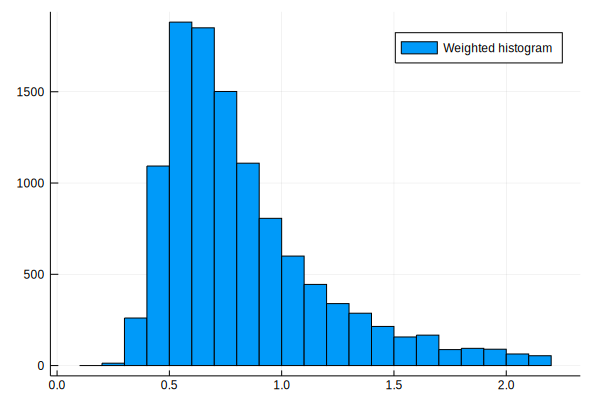

In [79]:
gr()
bins = collect(LinRange(0.1,2.2,22))
histogram(extra, label="Weighted histogram", bins=bins, weights=extra)
# png("histo_weighted")

In [12]:
gr()
s, e = 10, 197769
bar(s:10:e,extra[s:10:e], label="")
png("images/extras_distributed")

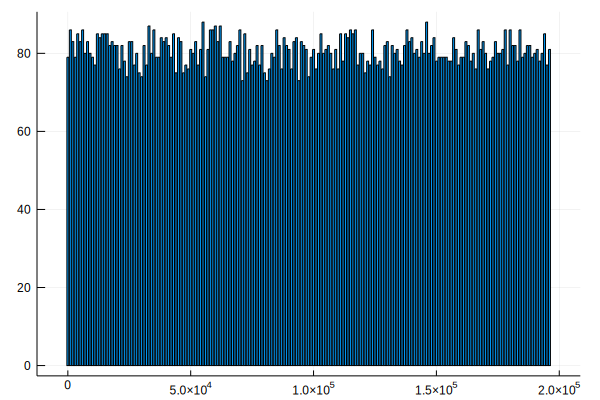

In [39]:
gr()
step_size = 1000
x = s:step_size:e-step_size
y = [sum(extra[i:i+step_size] .> 0) for i in x]
bar(x,y, label="")

In [49]:
function plot_one_k(k, step_length)
#    plot!(cities_csv[:X][prime_idx], cities_csv[:Y][prime_idx], markersize=4, markerstrokewidth=0, seriestype=:scatter,
#         size = (width, height), label="", color=:orange, axis=false)
    red_tenth_x = Plots.Segments()
    red_tenth_y = Plots.Segments()             
    green_tenth_x = Plots.Segments()
    green_tenth_y = Plots.Segments()   
    normal_x = Plots.Segments()
    normal_y = Plots.Segments()  
    for i=k:k+step_length
        if i+1 > length(subm_path)
            break
        end
        if tenth_and_noprime[i] == 1
           push!(red_tenth_x, cities_csv[:X][subm_path[i:i+1]])
           push!(red_tenth_y, cities_csv[:Y][subm_path[i:i+1]])
        elseif tenth_full[i]
           push!(green_tenth_x, cities_csv[:X][subm_path[i:i+1]])
           push!(green_tenth_y, cities_csv[:Y][subm_path[i:i+1]])               
        else
            push!(normal_x, cities_csv[:X][subm_path[i:i+1]])
            push!(normal_y, cities_csv[:Y][subm_path[i:i+1]]) 
        end
    end
    
#     for i=k:10:k+step_length
#         if i+9 > length(subm_path)
#             break
#         end
#        push!(normal_x, cities_csv[:X][subm_path[i:i+9]])
#        push!(normal_y, cities_csv[:Y][subm_path[i:i+9]])                           
#     end
    plot!(normal_x.pts, normal_y.pts, linewidth=1, 
          seriestype=:path,size = (width, height), color = :blue, label="", axis=false, 
          legend=false, colorbar=false)
    plot!(red_tenth_x.pts, red_tenth_y.pts, linewidth=4, 
          seriestype=:path,size = (width, height), color = :red, label="", axis=false, 
          legend=false, colorbar=false)
    plot!(green_tenth_x.pts, green_tenth_y.pts, linewidth=4, 
          seriestype=:path,size = (width, height), color = :green, label="", axis=false, 
          legend=false, colorbar=false)
    savefig("latest_"*string(k)*".png")
    println("k: ", k) 
end

counter = 1
ccolor = 1
tenth_full = [(i % 10) == 0 for i in 1:length(subm_path)]
tenth_and_noprime = cities.nprimes[subm_path] .* tenth_full
println(sum(tenth_and_noprime))

gr()
prime_idx = findall(cities_csv[:prime] .== true);
width = convert(Int,5100/4)
height = convert(Int,3400/4)
println("width: ", width)
width = 1920
height = 1080

# anim = Animation()
plot(cities_csv[:X][prime_idx], cities_csv[:Y][prime_idx], markersize=1, seriestype=:scatter,
    size = (width, height), label="", color=:orange, axis=false)
plot_one_k(1,length(subm_path))
#=
        frame(anim)
step_length = 20
for k = 1:step_length:10000 # step_length:length(subm_path)
    plot_one_k(k,step_length)
    frame(anim)
end
step_length = 100
for k = 10000:step_length:50000 # step_length:length(subm_path)
    plot_one_k(k,step_length)
    frame(anim)
end
step_length = 1000
for k = 50000:step_length:length(subm_path) # step_length:length(subm_path)
    plot_one_k(k,step_length)
    frame(anim)
end
println("Finished with anim")
for i = 1:100
    plot!()
    frame(anim)
end   
println("Finished with five extra seconds")


mp4(anim, "path_prime_20.mp4", fps = 20)
        =#


17983.0
width: 1275
k: 1
